## Mount Google Drive

In [ ]:
import os
import sys
from google.colab import drive

# Change according to your google drive's file path
workdir = "/content/drive/MyDrive/Internship/Diabetes(NSTEMI)/Development"

try:
    # Mount Drive
    drive.mount('/content/drive', force_remount=True)

    # Change Current Directory
    os.chdir(workdir)
    print("Current Working Directory: ", os.getcwd())

except Exception as e:
    print("Error: Failed to Mount Google Drive : ", e)

Mounted at /content/drive
Current Working Directory:  /content/drive/MyDrive/Internship/Diabetes(NSTEMI)/Development


## Import Libraries

In [ ]:
import joblib
import os
import sys
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

In [ ]:
# Add the uitilities into path
project_root = os.path.abspath('./utilities')

if project_root not in sys.path:
    sys.path.append(project_root)

# Import evaluation from the evaluation.py
from evaluation import evaluate, nri_score, calibrate_and_plot_with_nri


## Data and models

In [ ]:
# Import Files
X_train = joblib.load('./split/X_train.pkl')
y_train = joblib.load('./split/y_train.pkl')
X_test = joblib.load('./split/X_test.pkl')
y_test = joblib.load('./split/y_test.pkl')
X_calib = joblib.load('./split/X_cal.pkl')
y_calib = joblib.load('./split/y_cal.pkl')
timi_nstemi_test = joblib.load('./split/timi_nstemi_test.pkl')

In [ ]:
# Load Selected Features
selected_features = joblib.load('./selected_features/best_features.pkl')
print(selected_features)

['ptageatnotification', 'ptrace', 'killipclass', 'crenal', 'cardiaccath', 'pci', 'bb', 'acei', 'arb', 'calcantagonist', 'oralhypogly', 'antiarr', 'heartrate', 'bpsys', 'bpdias', 'ck', 'tc', 'hdlc', 'ldlc', 'tg', 'fbg']


In [ ]:
# Selected Features
X_train = X_train[selected_features]
X_test = X_test[selected_features]
X_calib = X_calib[selected_features]

In [ ]:
# NRI Testing: NA value will be excluded during evaluation will not be counted for improvement
timi_score_test = timi_nstemi_test

In [ ]:
# Load Models (Change accordingly)
stacked_ensemble = joblib.load('./models/stacked_ensemble.pkl')

In [ ]:
# Fixing label type error
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Stacked Ensemble


In [ ]:
for col in X_train.columns: # for xgb
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

In [ ]:
# Predict probabilities
y_true = y_test
y_prob = stacked_ensemble.predict_proba(X_test)[:, 1]

# convert missing value to -1
old_preds = timi_score_test.apply(lambda x: 1 if x >= 4 else (0 if pd.notna(x) else -1))

# Evaluate model and get threshold
best_threshold, metrics = evaluate(y_true, y_prob)

# Use threshold to binarize the new model prediction
new_preds = (y_prob > best_threshold).astype(int)

y_true = y_true.to_numpy() if hasattr(y_true, 'to_numpy') else y_true # if object then converts to NumPy array
old_preds = old_preds.to_numpy() if hasattr(old_preds, 'to_numpy') else old_preds
new_preds = new_preds.to_numpy() if hasattr(new_preds, 'to_numpy') else new_preds

# Use nri_score to compare with old predictions
nri_value = nri_score(y_true, old_preds, new_preds)


🔹 Threshold Used (Youden's J): 0.37
✔️ AUC-ROC Score (Test): 0.8298 (95% CI: 0.8039 - 0.8541)
✔️ Accuracy: 0.7384
✔️ Balanced Accuracy: 0.7589
✔️ Precision: 0.2562
✔️ Recall (Sensitivity): 0.7849
✔️ Specificity: 0.7330
✔️ F1-score: 0.3863
✔️ F2-Score: 0.5556
✔️ Brier Score: 0.1341

Confusion Matrix:
 [[1570  572]
 [  54  197]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9667    0.7330    0.8338      2142
           1     0.2562    0.7849    0.3863       251

    accuracy                         0.7384      2393
   macro avg     0.6115    0.7589    0.6100      2393
weighted avg     0.8922    0.7384    0.7868      2393

🧹 Removed 5 rows with Old Model Prediction = -1 (missing values).

🔹 Reclassification Summary:
✔️ Correctly Upgraded (0 → 1, actual = 1): 107
❌ Incorrectly Upgraded (0 → 1, actual = 0): 343
✔️ Correctly Downgraded (1 → 0, actual = 0): 564
❌ Incorrectly Downgraded (1 → 0, actual = 1): 26

📊 Events (actual = 1): 251, N

In [ ]:
explainer = shap.Explainer(stacked_ensemble.predict_proba, X_train) # creates a SHAP explainer for your stacked ensemble model
shap_values = explainer(X_test)

PermutationExplainer explainer: 2394it [31:53,  1.25it/s]


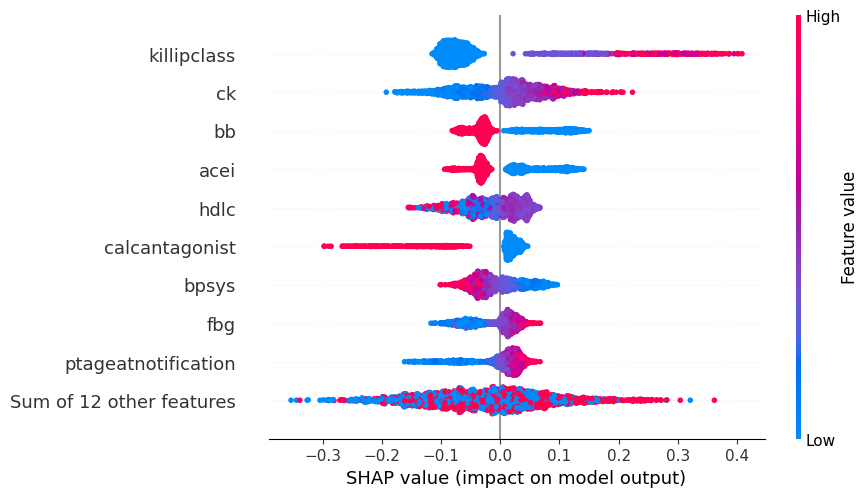

In [ ]:
shap.plots.beeswarm(shap_values[..., 1]) # (sample, feature, class) so need ...class 1
plt.show()

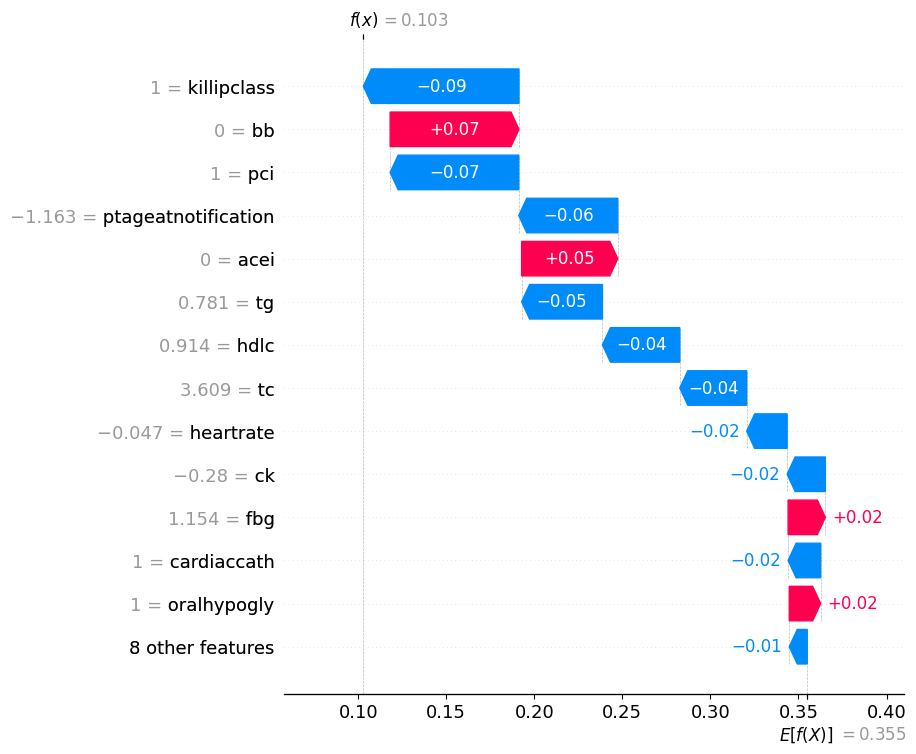

In [ ]:
# Set the figure size BEFORE the plot
plt.figure(figsize=(10, 6))  # Width x Height in inches

# Plot SHAP waterfall for the first instance
shap.plots.waterfall(shap_values[18, :, 1], max_display=14)  # Optional: limit features shown
plt.show()